In [201]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from matplotlib import pyplot
from prophet import Prophet
import datetime

In [202]:
#load data as dataframe with Pandas
df_train = pd.read_csv("test_data_scientist/train.csv")
df_test = pd.read_csv("test_data_scientist/test.csv")
df_bu_feat = pd.read_csv("test_data_scientist/bu_feat.csv")

In [203]:
#convert "day_id" columns into a datetime column 
df_train["day_id"] = pd.to_datetime(df_train["day_id"], format="%Y-%m-%d")
df_test["day_id"] = pd.to_datetime(df_test["day_id"], format="%Y-%m-%d")

In [7]:
len(list(df_train["but_num_business_unit"].unique())),len(list(df_train["dpt_num_department"].unique()))

(322, 4)

In [8]:
list(df_train["dpt_num_department"].unique())

[127, 88, 73, 117]

In [9]:
# To forecast the turnover at store-department level, to be as much precise as possible, a model should be built for each
# business_unit-department, meaning 322*4=1288 models.
# It is too much. We need to find some ways to reduce this number.

In [10]:
#add features related to date
df_train["year"] = df_train["day_id"].dt.year
df_train["month"] = df_train["day_id"].map(lambda x: x.strftime('%m'))
df_train["week"] = df_train["day_id"].map(lambda x: x.strftime('%W'))

In [11]:
df_train_grouped = df_train.groupby(["dpt_num_department","but_num_business_unit","year","month","week"]).sum().reset_index()
df_train_grouped = df_train_grouped[["turnover","dpt_num_department","but_num_business_unit","year","month","week"]]

In [12]:
#remove rows where no turnover have been made
df_train_grouped = df_train_grouped[df_train_grouped["turnover"]>=0]

In [14]:
#Idées :

#voir pour regrouper les sports ou les magasins si ils ont le même pattern

#representation des sports par magasin -> potentiellement faire forecast sur CA total du magasin 
#et on applique le pourcentage pour avoir le sport

#representation du CA du magasin dans la region ou sur le CA total 
# -> au fil du temps, toujours la même part de CA dans le CA total
# -> au fil du temps, toujours la même part de CA dans le CA region
# ->-> potentiellement faire forecast CA total et appliquer le pourcentage pour avoir le magasin

#évolution du CA du sport en fonction de la période. Some seasonalities have been observed in the first part.

In [15]:
#representation des sports par magasin

In [17]:
df_sport_magasin_year = df_train_grouped[["but_num_business_unit","dpt_num_department","turnover"]].copy()
df_sport_magasin_year = df_sport_magasin_year.groupby(["but_num_business_unit","dpt_num_department"]).sum()

In [19]:
df_sport_magasin_year["percentage"] = df_sport_magasin_year.groupby(level=0).apply(lambda x:x / float(x.sum()))

In [20]:
df_sport_magasin_year.head()

turnover  percentage
but_num_business_unit dpt_num_department                           
1                     73                   10727.897559    0.026964
                      88                   84318.204258    0.211927
                      117                  75854.560702    0.190654
                      127                 226964.061391    0.570455
2                     73                   14738.507274    0.036418

In [21]:
df_sport_magasin_year_filt = df_sport_magasin_year.reset_index()

In [22]:
df_sport_magasin_year_filt = df_sport_magasin_year_filt[df_sport_magasin_year_filt["percentage"].isnull()!=True]

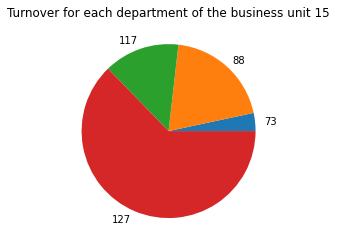

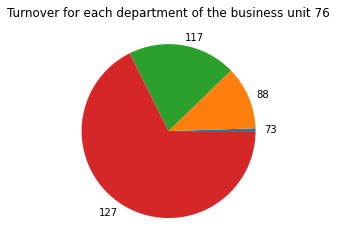

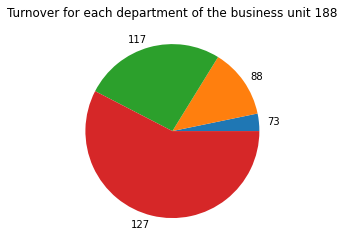

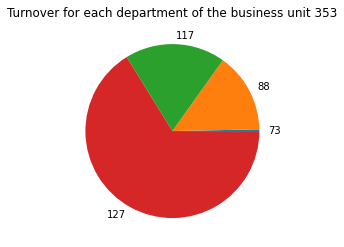

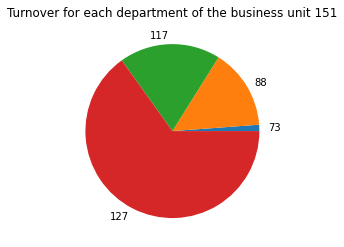

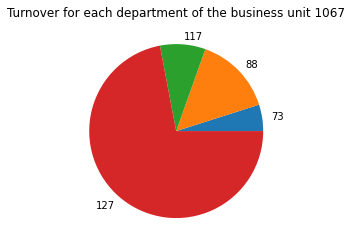

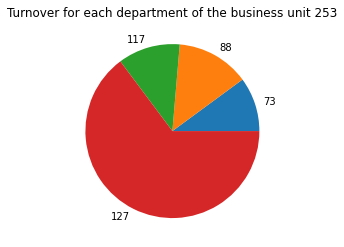

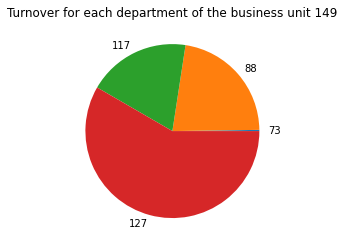

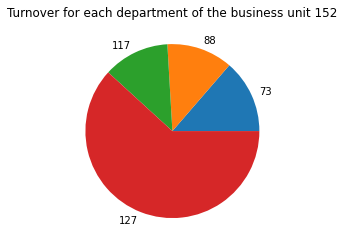

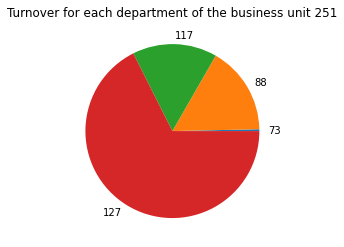

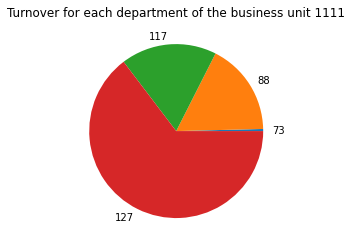

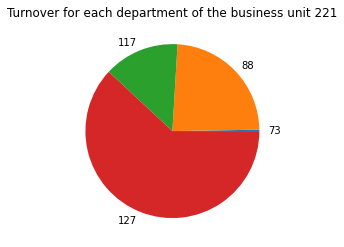

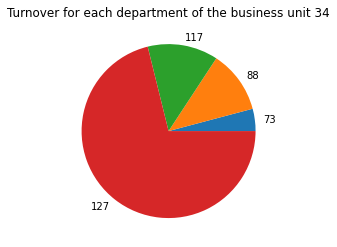

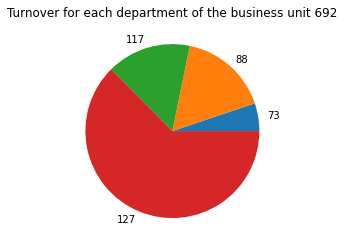

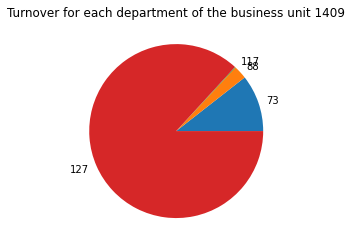

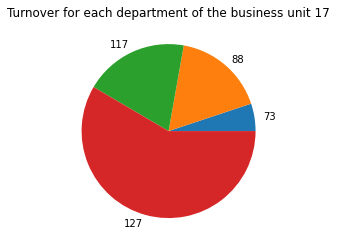

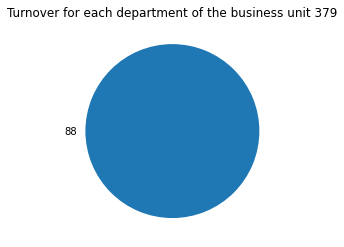

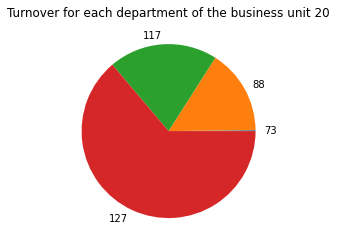

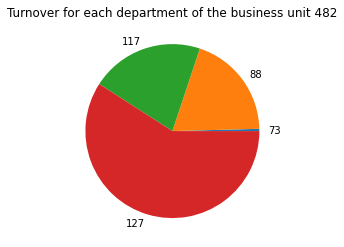

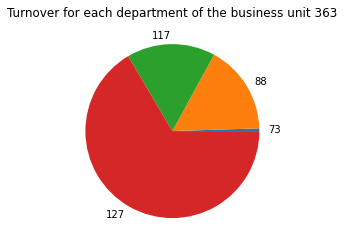

In [23]:
random_business_unit = random.sample(list(df_sport_magasin_year_filt["but_num_business_unit"].unique()),20)
for i, bu in enumerate(random_business_unit):
    filt_bu = (df_sport_magasin_year_filt["but_num_business_unit"]==bu)
    df_filt_plot = df_sport_magasin_year_filt[filt_bu]
    plt.figure(i)
    plt.title(f"Turnover for each department of the business unit {bu}")
    plt.pie(df_filt_plot['percentage'],labels=df_filt_plot['dpt_num_department'])

In [24]:
# from the plot above, we can conclude that for all the business unit, the sport representation of each 
# department in the yearly turnover of the business units is similar.
# It means that the forecast of the global turnover can be made and then the percentage of representation of each 
# department will be applied.

#for more precision, could be better to use regions.

In [25]:
# find the percentage of each department

In [28]:
repres_department = list()
department = list()
for dep in list(df_sport_magasin_year_filt["dpt_num_department"].unique()):
    filt_dep = df_sport_magasin_year_filt["dpt_num_department"]==dep
    df_dep = df_sport_magasin_year_filt[filt_dep]
    mean_val = df_dep["percentage"].mean()
    department.append(dep)
    repres_department.append(mean_val)
    print(f'Department {dep} : percentage representation mean : {mean_val}')
df_department_repres = pd.DataFrame(list(zip(department, repres_department)),columns =["dpt_num_department", "department_percentage"])

Department 73 : percentage representation mean : 0.03761403011554026
Department 88 : percentage representation mean : 0.17275834757465275
Department 117 : percentage representation mean : 0.17057306967774374
Department 127 : percentage representation mean : 0.628078165019278


In [29]:
#NOT USED
#étude du CA de chaque magasin en fonction du CA total par semaine

In [30]:
df_turnover_bu_weeek = df_train_grouped[["but_num_business_unit","turnover","week","year"]]
df_turnover_bu_weeek[(df_turnover_bu_weeek["year"]==2016) & (df_turnover_bu_weeek["week"]=='20')].head(5)
#calcul du pourcentage de representation du CA du magasin chaque semaine en fonction du CA total par semaine
df_ = pd.DataFrame(columns=["year","week","but_num_business_unit","turnover","percentage"])
for year in list(df_turnover_bu_weeek["year"].unique()):
    df_turnover_bu_weeek_filt = df_turnover_bu_weeek[df_turnover_bu_weeek["year"]==year]
    df_turnover_bu_weeek_filt = df_turnover_bu_weeek_filt[["week","but_num_business_unit","turnover"]]
    df_turnover_bu_weeek_filt = df_turnover_bu_weeek_filt.groupby(["week","but_num_business_unit"]).sum()
    df_turnover_bu_weeek_filt["percentage"] = df_turnover_bu_weeek_filt.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2))
    df_turnover_bu_weeek_filt = df_turnover_bu_weeek_filt.reset_index()
    df_turnover_bu_weeek_filt["year"] = year
    df_ = pd.concat([df_,df_turnover_bu_weeek_filt])

In [34]:
df_std_week_bu = df_[["week","but_num_business_unit","percentage"]].groupby(["but_num_business_unit","week"]).std()
df_std_week_bu = df_std_week_bu.reset_index()
df_std_week_bu.rename(columns={'percentage':'std_percentage'},inplace=True)
df_std_week_bu[df_std_week_bu["std_percentage"]>0.6]

<AxesSubplot:>

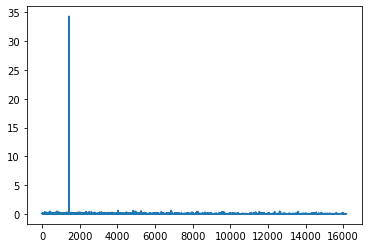

In [36]:
df_std_week_bu["std_percentage"].plot()

In [37]:
# from the dataframe above and the plot above, we can understand that all standard deviation are very small
# except for business unit 30 week 43. Nous le considèrerons comme outlier.

In [38]:
2*df_std_week_bu[df_std_week_bu["std_percentage"]<34]["std_percentage"].max()

1.228055373344378

In [39]:
# au fil du temps, le pourcentage de CA weekly du business unit par rapport au CA weekly de tous les business unit 
# varie au maximum de 1,23% (en enlevant notre business unit 30 week 43 qui s'apparente à un outlier).

# on peut donc considérer que la prédiction du CA weekly du business unit pourra être calculer grâce à la prédiction du CA 
# weekly de l'ensemble des business unit en appliquant le pourcentage de représentation du business unit.

In [40]:
#pourcentages à appliquer
df_mean_turnover_week_bu_perc = df_.groupby(["week","but_num_business_unit"]).mean().reset_index()
df_mean_turnover_week_bu_perc[["week","but_num_business_unit","percentage"]].head()

,week,but_num_business_unit,percentage
0,00,1,0.2750
1,00,2,0.1950
2,00,4,0.8375
3,00,5,0.8175
4,00,6,0.3975


In [41]:
# étude du CA de chaque magasin en fonction du CA total sur 1 année

In [208]:
df_turnover_bu = df_train_grouped[["but_num_business_unit","turnover","year"]].groupby(["year","but_num_business_unit"]).sum()
#calcul representation CA magasin en fonction du CA total sur l'année
df_turnover_bu_perc = df_turnover_bu.copy()
df_turnover_bu_perc["bu_percentage"] = df_turnover_bu_perc.groupby(level=0).apply(lambda x:x / float(x.sum()))
df_turnover_bu_perc = df_turnover_bu_perc.reset_index()
df_turnover_bu_perc.head(2)

,year,but_num_business_unit,turnover,bu_percentage
0,2012,1,1961.070225,0.002578
1,2012,2,1785.872047,0.002348


In [209]:
df_turnover_bu_perc_std = df_turnover_bu_perc[["but_num_business_unit","bu_percentage"]].groupby(["but_num_business_unit"]).std()
df_turnover_bu_perc_std.rename(columns={'bu_percentage':'std_percentage'},inplace=True)
df_turnover_bu_perc_std = df_turnover_bu_perc_std.reset_index()

In [210]:
# for some business unit, we have NaN std. 
bu_nan = list(df_turnover_bu_perc_std[df_turnover_bu_perc_std["std_percentage"].isnull()]["but_num_business_unit"])
df_t = df_turnover_bu.reset_index()
df_t[df_t["but_num_business_unit"].isin(bu_nan)].head()

,year,but_num_business_unit,turnover
1698,2017,1607,20352.977338
1699,2017,1608,38103.403663
1700,2017,1609,32667.526808
1702,2017,1616,16503.107071
1704,2017,1869,17729.073768


In [ ]:
# the nan std comes from business units that exist only since 2017.

<AxesSubplot:xlabel='but_num_business_unit', ylabel='std_percentage'>

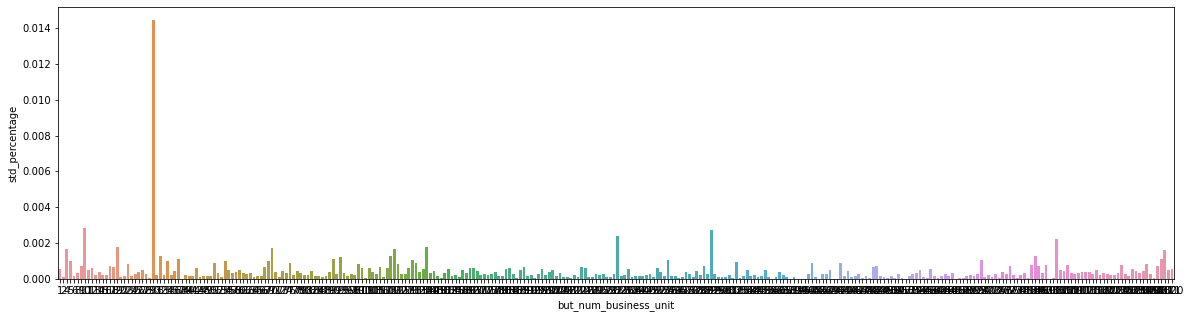

In [211]:
df_ = df_turnover_bu_perc_std[df_turnover_bu_perc_std["std_percentage"].notnull()]
fig, ax = pyplot.subplots(figsize=(20,5))
sns.barplot(ax=ax,data=df_,x="but_num_business_unit",y="std_percentage")

In [212]:
df_turnover_bu_perc_std[df_turnover_bu_perc_std["std_percentage"]>0.2]
print(2*df_turnover_bu_perc_std["std_percentage"].max())

# au fil du temps, le pourcentage de CA du business unit par rapport au CA de tous les business unit varie au maximum de 3%.

# on peut donc considérer que la prédiction du CA du business unit pourra être calculer grâce à la prédiction du CA 
# de l'ensemble des business unit en appliquant le pourcentage de représentation du business unit.

#pourcentages à appliquer
df_mean_turnover_bu_perc = df_turnover_bu_perc.groupby("but_num_business_unit").mean().reset_index()
df_mean_turnover_bu_perc = df_mean_turnover_bu_perc[["but_num_business_unit","bu_percentage"]]
df_mean_turnover_bu_perc.head()

0.028890278961057895


,but_num_business_unit,bu_percentage
0,1,0.002654
1,2,0.002562
2,4,0.007135
3,5,0.008335
4,6,0.003923


In [46]:
#analyse turnover for the different departments along the time

In [121]:
df_turn_dep = df_train[["day_id","dpt_num_department","turnover"]]

<Figure size 432x288 with 0 Axes>

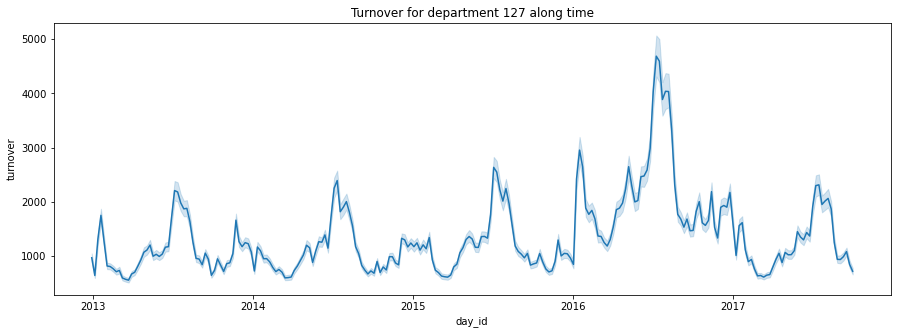

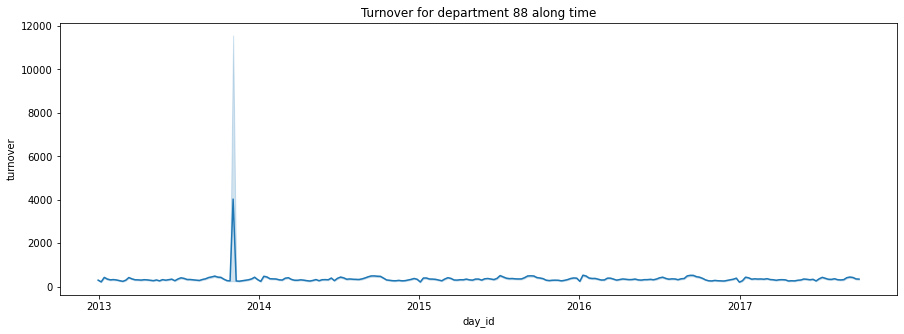

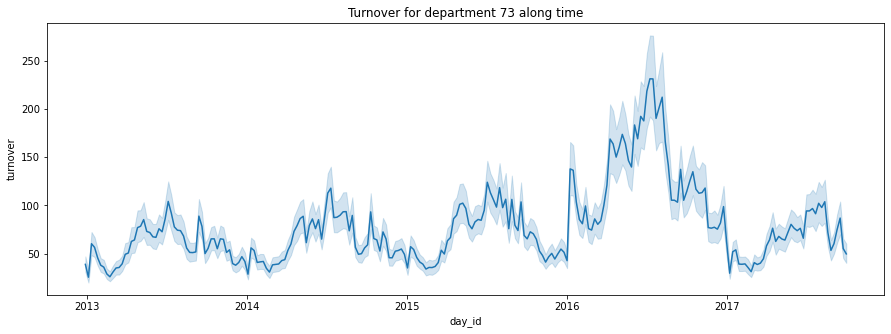

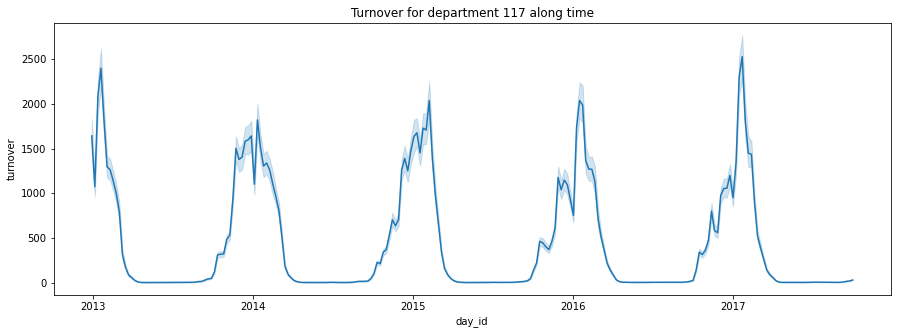

In [122]:
for i, dep in enumerate(list(df_turn_dep["dpt_num_department"].unique())):
    df_turn_dep_filt = df_turn_dep[(df_turn_dep["dpt_num_department"]==dep)]
    plt.figure(i)
    fig, ax = pyplot.subplots(figsize=(15,5))
    plt.title(f"Turnover for department {dep} along time")
    sns.lineplot(ax=ax,data=df_turn_dep_filt, x='day_id', y='turnover',palette="tab10")

In [123]:
# from these plots, we can definitely seen some beautiful seasonalities with proportional values.
# It means that we can consider that the percentage of the turnover of the departments at a certain week can be use along time.

In [124]:
# add week feature to be able to make precise groups
df_turn_dep["week"] = df_turn_dep["day_id"].dt.isocalendar().week

/home/louis/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [125]:
#percentage turnover by department by week
df_turn_dep_gr = df_turn_dep.groupby(["dpt_num_department","week"]).sum()
df_turn_dep_gr["week_percentage"] = df_turn_dep_gr.groupby(level=0).apply(lambda x:x / float(x.sum()))

In [127]:
df_perc_dep_week = df_turn_dep_gr.reset_index()[["dpt_num_department","week","week_percentage"]]
df_perc_dep_week.head()

,dpt_num_department,week,week_percentage
0,73,1,0.012898
1,73,2,0.018105
2,73,3,0.016148
3,73,4,0.012914
4,73,5,0.012113


In [54]:
# We can now work on the global turnover forecast

In [56]:
df_forecast_turnover = df_train[["day_id","turnover"]]
df_forecast_turnover = df_forecast_turnover.groupby("day_id").sum().reset_index()
df_forecast_turnover.head(2)

,day_id,turnover
0,2012-12-29,760549.928211
1,2013-01-05,506344.523372


<AxesSubplot:title={'center':'Turnover along time'}, xlabel='day_id', ylabel='turnover'>

<Figure size 432x288 with 0 Axes>

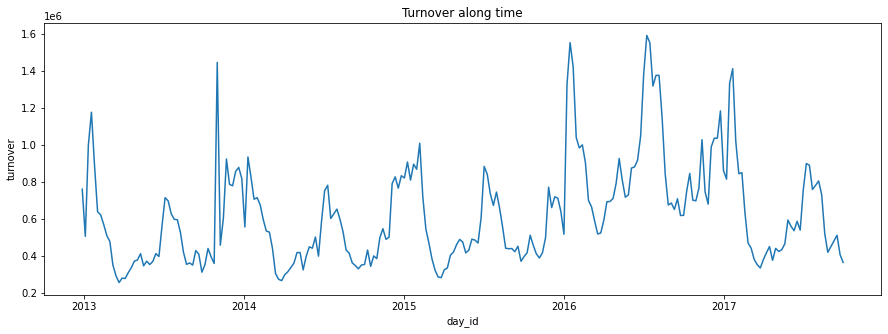

In [57]:
plt.figure(i)
fig, ax = pyplot.subplots(figsize=(15,5))
plt.title(f"Turnover along time")
sns.lineplot(ax=ax,data=df_forecast_turnover, x='day_id', y='turnover',palette="tab10")

In [58]:
#train test split
# Define threshold date = we are going to forecast the last months of train dataset : august and september 2017
threshold_date = pd.to_datetime('2017-07-30')
df = df_forecast_turnover
df = df.rename(columns={"day_id":"ds","turnover":"y"})
mask = df['ds'] < threshold_date
# Split the data and select `ds` and `y` columns.
df_train_fc = df[mask][['ds', 'y']]
df_test_fc= df[~ mask][['ds', 'y']]

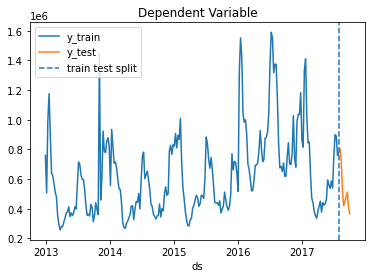

In [59]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y_train', data=df_train_fc, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test_fc, ax=ax)
ax.axvline(threshold_date, linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

In [60]:
m = Prophet(yearly_seasonality=True,weekly_seasonality=False,daily_seasonality=False)
m.fit(df_train_fc)

In [61]:
future = m.make_future_dataframe(periods=df_test_fc.shape[0], freq='W')

In [62]:
forecast = m.predict(df=future)

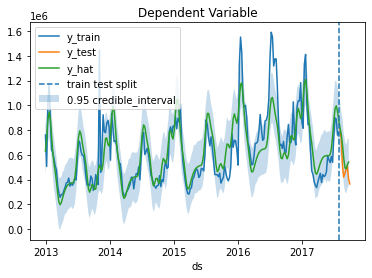

In [63]:
mask2 = forecast['ds'] < threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train_fc, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test_fc, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

In [64]:
import numpy as np

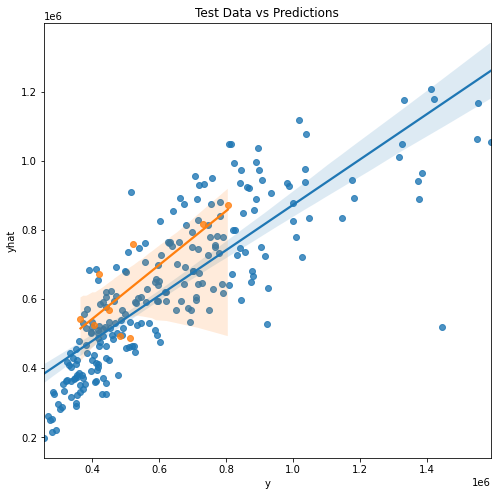

In [65]:
fig, ax = plt.subplots(figsize=(8,8))

# Generate diagonal line to plot. 
#d_x = np.linspace(start=df_train_fc['y'].min() - 1, stop=df_train_fc['y'].max() + 1, num=100)

sns.regplot(x=df_train_fc['y'], y=forecast_train['yhat'],label='train', ax=ax)
sns.regplot(x=df_test_fc['y'], y=forecast_test['yhat'], label='test', ax=ax)
#sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, ax=ax)
#ax.lines[2].set_linestyle('--')
ax.set(title='Test Data vs Predictions');

In [66]:
from sklearn.metrics import r2_score, mean_absolute_error

print('r2 train: {}'.format(r2_score(y_true=df_train_fc['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test_fc['y'], y_pred=forecast_test['yhat'])))
print('---')
print('mae train: {}'.format(mean_absolute_error(y_true=df_train_fc['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test_fc['y'], y_pred=forecast_test['yhat'])))

r2 train: 0.6842241224861625
r2 test: -0.06914066020989806
---
mae train: 110421.68315068693
mae test: 120849.6429990961


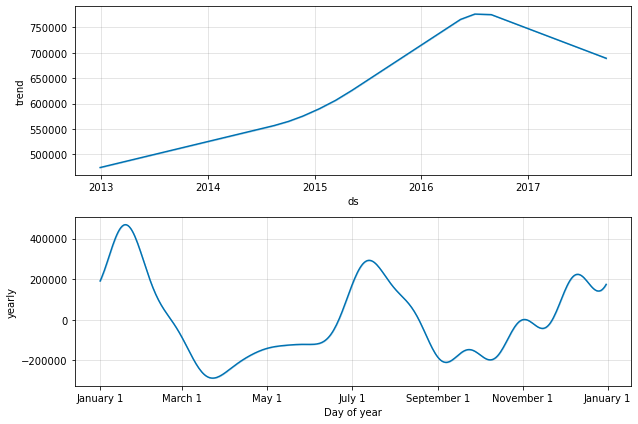

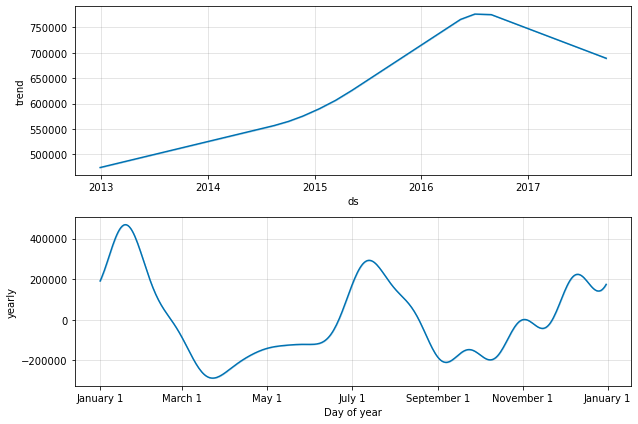

In [67]:
m.plot_components(forecast)

In [68]:
# predict on test dataset

In [128]:
future_test = pd.DataFrame({'ds': list(df_test["day_id"].unique())})
prediction_test = m.predict(future_test)

In [129]:
df_test_pred = prediction_test[["ds","yhat"]]

In [130]:
#calcul de la semaine
df_test_pred["week"] = df_test_pred["ds"].map(lambda x: x.strftime('%W'))

/home/louis/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [131]:
#find date 1 year ago
date_one_year = df_test_pred["ds"].max() - datetime.timedelta(days=365)
date_one_year

Timestamp('2016-11-25 00:00:00')

In [189]:
#filt train data to obtain one year
filt_date = df_train["day_id"] >= date_one_year
turnover_train_part = df_train[filt_date]["turnover"].sum()
turnover_test_part = df_test_pred["yhat"].sum()

In [190]:
#calculate turnover for the one year (rolling)
turnover_rolling_year = turnover_train_part+turnover_test_part
print(turnover_rolling_year)

34595531.06909541


In [191]:
#apply percentage for each business unit to obtain turnover per business unit on the year
df_result = df_mean_turnover_bu_perc.copy()
df_result["turnover_bu"] = df_result["bu_percentage"]*turnover_rolling_year

In [192]:
#apply percentage for each department to obtain turnover per department per business unit
cols = list(df_department_repres.columns)
df_department_repres_all = pd.DataFrame(columns=cols)
df_department_repres_all = df_department_repres_all.append([df_department_repres]*322,ignore_index=True)

cols = list(df_result.columns)
df_result_1 = pd.DataFrame(columns=cols)
df_result_1 = df_result_1.append([df_result]*4,ignore_index=True)
df_result_1.sort_values(by="but_num_business_unit",inplace=True)
df_result_1 = df_result_1.reset_index(drop=True)

df_result_2 = pd.concat([df_result_1,df_department_repres_all],axis=1)

In [193]:
#apply percentage of department
df_result_2["turnover_bu_dep"] = df_result_2["turnover_bu"]*df_result_2["department_percentage"]
df_result_2 = df_result_2[["but_num_business_unit","dpt_num_department","turnover_bu_dep"]]

In [194]:
#apply percentage from department on the week to have final turnover
df_perc_dep_week_filt = df_perc_dep_week[df_perc_dep_week["week"].isin(list(df_test_pred["week"]))]
df_perc_dep_week_filt = df_perc_dep_week_filt.reset_index(drop=True)
df_result_3 = pd.merge(df_result_2, df_perc_dep_week_filt, on="dpt_num_department", how="outer")
df_result_3["turnover_pred"] = df_result_3["turnover_bu_dep"]*df_result_3["week_percentage"]

In [ ]:
#prepare types for merging with test dataset
df_result_3 = df_result_3[["but_num_business_unit","dpt_num_department","week","turnover_pred"]]
df_result_3["dpt_num_department"] = df_result_3["dpt_num_department"].astype("int")
df_result_3["but_num_business_unit"] = df_result_3["but_num_business_unit"].astype("int")

df_test["week"] = df_test["day_id"].map(lambda x: x.strftime('%W'))
df_test["week"] = df_test["week"].astype("int")

df_result_final = df_test.merge(df_result_3,on=["but_num_business_unit","dpt_num_department","week"],how="left")
df_result_final.head(2)